# Custom DFT for hi-res low-freqs spectrograms

In [0]:
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80

In [47]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.0 GB  | Proc size: 5.7 GB
GPU RAM Free: 130MB | Used: 11309MB | Util  99% | Total 11439MB


In [0]:
from google.colab import files
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import sys
# plt.rcParams['figure.figsize'] = [20, 20]
# plt.rcParams['figure.figsize'] = [30, 30]
plt.rcParams['figure.figsize'] = [12, 12]

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving lead.wav to lead.wav
User uploaded file "lead.wav" with length 377750 bytes


In [2]:
!ls

datalab  lead.wav


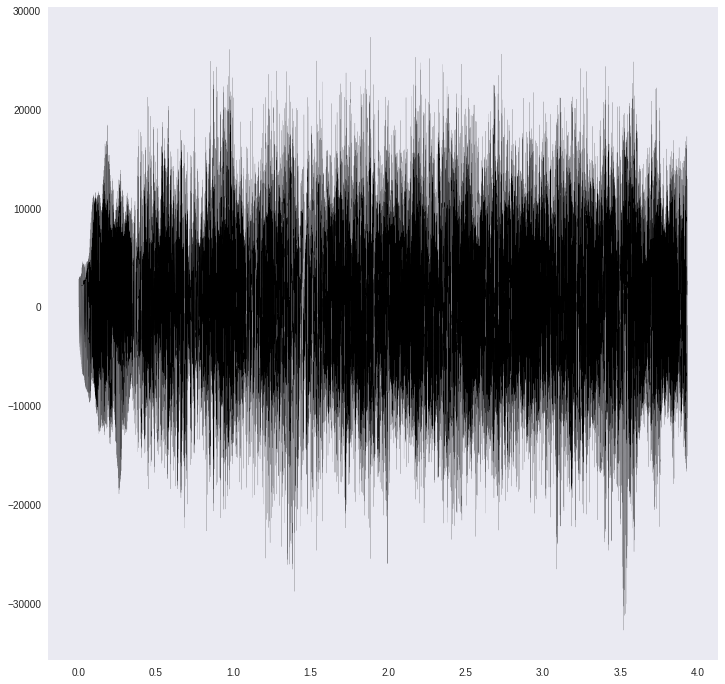

In [3]:
from scipy.io import wavfile
rate, x = wavfile.read('lead.wav')
signal = x
# signal = x[:20000]
# left_channel  = x[:, 0]
# right_channel = x[:, 1]
# signal = left_channel
# signal = (left_channel + right_channel) / 2 # average left and right channels to mono signal // reaaly bad, don't do this
N = len(signal)
t = np.linspace(0, N/rate, N)
plt.grid()
plt.plot(t, signal, 'k-', linewidth=0.1)

# Unoptimised spectrogram using `for` loop

In [17]:
from scipy.signal import tukey, gaussian


nperseg  = 11025 // 5
# noverlap = nperseg -1
noverlap = nperseg // 100 * 98

step = nperseg - noverlap
f_N = nperseg // 1
spectrogram = np.empty( ((signal.shape[-1] - noverlap) // step, f_N) )
t_chunk = np.linspace(0, nperseg / rate, nperseg)
f = np.logspace(np.log10(30), np.log10(nperseg//2), f_N) # second arg: nperseg//2 (Nyquist limit)
# f       = np.geomspace(30, nperseg//2, f_N) # second arg: nperseg//2 (Nyquist limit)


T_chunk, F_chunk = np.meshgrid(t_chunk, f)
E = cp.array(np.exp(-2j * np.pi * F_chunk * T_chunk))


lines_for_plot_windows = []
# blur_kernel = gaussian(50, std=3)
blur_kernel = gaussian(50, std=10)
# acoustic_filter = 12200**2 * f**2 / (f**2 + 20.6**2) / (f**2 + 12200**2) # siggigue.github.io/pyfilterbank/splweighting.html


j = 0
for i in range(0, N, step):
    if j % 20 == 0:
        sys.stdout.write('\r')
        sys.stdout.write(f'{j + 1}/{spectrogram.shape[0]}')
        sys.stdout.flush()

    chunk = cp.array(signal[i : i + nperseg])
    
    if E.shape[1] == chunk.shape[0]:
#         print(chunk.shape, np.hanning(nperseg).shape)
#         chunk = chunk * np.hamming(nperseg)
#         chunk = chunk * np.bartlett(nperseg)
#         chunk = chunk * np.blackman(nperseg)
#         chunk = chunk * gaussian(nperseg, std=0.1)
        
#         corr = E @ chunk
    
        corr = cp.dot(E, chunk)
    
        magnitude = np.abs(corr.get())
        
#         magnitude = np.abs(corr)
        
#         lines_for_plot_windows.append(t[i])
#         lines_for_plot_windows.append(t[i + nperseg])
        
        
        
#         magnitude[magnitude < magnitude.max()/4] = 0
        
#         magnitude = magnitude * np.geomspace(1, 10000, f_N) # high freqs saturation
  
        maximas_mask = np.r_[True, magnitude[1:] > magnitude[:-1]] & np.r_[magnitude[:-1] > magnitude[1:], True]

        sharp_peaks = np.zeros_like(magnitude)
        sharp_peaks[maximas_mask] = magnitude[maximas_mask]
        
#         threshold = np.max(sharp_peaks) / 10
#         threshold = np.sort(magnitude[maximas_mask])[-2] # take only n peaks
#         sharp_peaks[sharp_peaks < threshold] = 0 # filter out small maximas
#         sharp_peaks[maximas_mask] = 1
  
#         spectrogram[j] = np.correlate(sharp_peaks, blur_kernel, mode='same') * acoustic_filter
#         spectrogram[j] = np.correlate(sharp_peaks, blur_kernel, mode='same') * f
        spectrogram[j] = np.correlate(sharp_peaks, blur_kernel, mode='same')
#         spectrogram[j] = magnitude
#         spectrogram[j] = sharp_peaks
        j += 1
sys.stdout.write('\r')
sys.stdout.write(f'{spectrogram.shape[0]}/{spectrogram.shape[0]}')

3810/3810

In [18]:
# E = None
# chunk = None
# corr = None
printm()

NameError: ignored

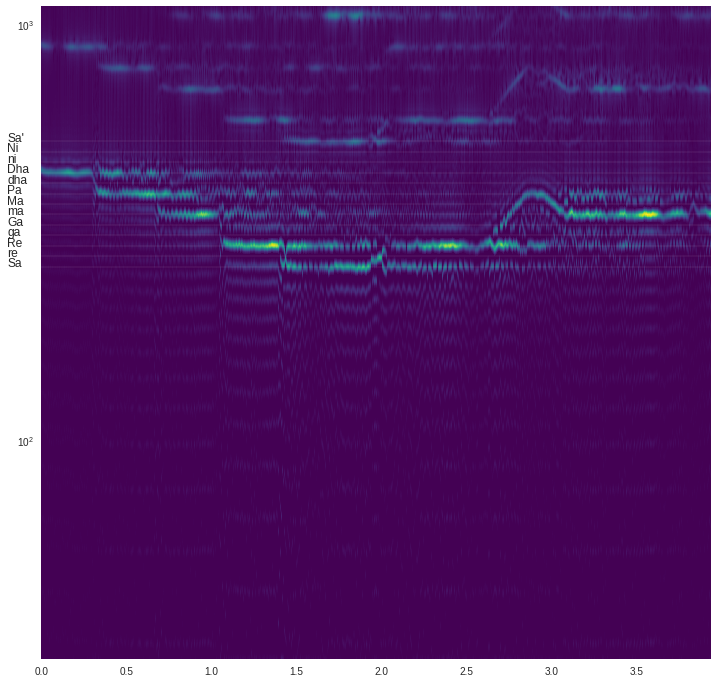

In [19]:
t_for_spectrogram = np.linspace(0, N/rate, j)
T, F = np.meshgrid(t_for_spectrogram, f)

spec_filtered = np.copy(spectrogram.T)
# spec_filtered = np.clip(spectrogram.T, 0, 500000000)
# spec_filtered = np.clip(spectrogram.T, 0, 1000000000)
# spec_filtered = 20 * np.log10(spec_filtered)
# print(T.shape, F.shape, spec_filtered.shape)
# spec_filtered[spec_filtered < 2000000] = 0

plt.pcolormesh(T, F, spec_filtered, cmap='viridis')
# plt.pcolormesh(T, F, spec_filtered, cmap='viridis', vmax=40000000)
# slize_start = 6000
# slize_end = 8000
# plt.pcolormesh(T[:slize], F[:slize], spec_filtered[:slize, :], cmap='viridis', vmax=5000000)
# plt.pcolormesh(T[slize_start:slize_end], F[slize_start:slize_end], spec_filtered[slize_start:slize_end, :], cmap='viridis', vmax=5000000)

sa = 261.63 # C4 Hz
semitones_range = np.arange(13)
freqlines = sa * 2**(semitones_range/12)
notes = ['Sa', 're', 'Re', 'ga', 'Ga', 'ma', 'Ma', 'Pa', 'dha', 'Dha', 'ni', 'Ni', 'Sa\'']

for freq, note in zip(freqlines, notes):
  plt.text(-0.2, freq, note, fontsize=12)

# freqlines = np.array([261, 350, 372, 415, 522])
plt.semilogy()
plt.hlines(freqlines, xmin=0, xmax=N/rate, linewidth=0.1, color='w', label='Sa')

# plt.vlines(lines_for_plot_windows, ymin=f[0], ymax=f[-1], linewidth=0.1, color='w')

# plt.text(-0.2, 261, 'Sa', fontsize=12)
# plt.text(-0.2, 350, 'ma', fontsize=12)
# plt.text(-0.2, 372, 'Ma', fontsize=12)
# plt.text(-0.2, 415, 'dha', fontsize=12)
# plt.text(-0.2, 522, 'Sa', fontsize=12)

# plt.hlines(f, xmin=0, xmax=400, linewidth=1, color='w')
# plt.axhline(y=261, linewidth=1, color='w')
plt.grid(False)
plt.show()

In [0]:
with open('spectrogram.png', 'wb') as f:
  plt.imsave(f, spec_filtered, cmap='viridis', origin='lower')
files.download('spectrogram.png')

In [45]:
spec_filtered[:1000, :].shape

(1000, 1686)

In [0]:
 a = spectrogram[123]

# stackoverflow.com/a/4625132/4204843
# z = np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True] # minimas
z = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True] # maximas

gg = np.zeros(len(a))
gg[z] = a[z]
plt.plot(f, spectrogram[123])
plt.plot(f, gg)
plt.grid(False)

In [62]:
cc = np.array([0, 1, 2, 3, 4, 2, 1, 2, 4, 7 ,8, 7, 1])
nn = len(cc)
zz = np.r_[True, cc[1:] > cc[:-1]] & np.r_[cc[:-1] > cc[1:], True] # maximas
print(zz)
gg = np.zeros(nn)

gg[zz] = cc[zz]
gg
# cc[zz]

[False False False False  True False False False False False  True False
 False]


array([0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 8., 0., 0.])

In [0]:
f = np.linspace(0, N//4, N*2)
T, F = np.meshgrid(t, f)
E = np.exp(-2j * np.pi * F * T)

corr = E @ signal
# magnitude = 20 * np.log10(np.abs(corr))
magnitude = np.abs(corr)

# slic = 100

# plt.plot(f[:slic], magnitude[:slic])
plt.plot(f, magnitude)

# corr.shape
# corr

In [0]:
x = np.arange(8)
x
nperseg  = 3
noverlap = 2
step = nperseg - noverlap

((x.shape[-1] - noverlap) // step, nperseg)
# x.shape
# x.shape[-1] 

(6, 3)

# finding bugs

In [165]:
nperseg  = 11025//8
noverlap = nperseg // 100 * 92
step = nperseg - noverlap
f_N = nperseg // 1
spectrogram = np.empty( ((signal.shape[-1] - noverlap) // step, f_N) )
t_chunk = np.linspace(0, nperseg / rate, nperseg)
f       = np.geomspace(30, nperseg//2, f_N) # second arg: nperseg//2 (Nyquist limit)


T_chunk, F_chunk = np.meshgrid(t_chunk, f)
E = np.exp(-2j * np.pi * F_chunk * T_chunk)

j = 0
for i in range(0, N, step):
    if j % 20 == 0:
      print(f'{j + 1}/{spectrogram.shape[0]}', end=' ')
    if(j % 100 == 0):
#     if j % 15 == 0:
      print('\n', end='')
    chunk = signal[i : i + nperseg]
    
    if E.shape[1] == chunk.shape[0]:
#         print(chunk.shape, np.hanning(nperseg).shape)
#         chunk = chunk * np.hamming(nperseg)
#         chunk = chunk * np.bartlett(nperseg)
        chunk = chunk * np.blackman(nperseg)
        corr = E @ chunk
        
        magnitude = np.abs(corr)
        
        
#         magnitude[magnitude < magnitude.max()/4] = 0
        
#         magnitude = magnitude * np.geomspace(1, 10000, f_N) # high freqs saturation
  
        maximas_mask = np.r_[True, magnitude[1:] > magnitude[:-1]] & np.r_[magnitude[:-1] > magnitude[1:], True]

        sharp_peaks = np.zeros_like(magnitude)
        sharp_peaks[maximas_mask] = magnitude[maximas_mask]
        
#         threshold = np.max(sharp_peaks) / 10
#         threshold = np.sort(magnitude[maximas_mask])[-5] # take only 10 peaks
#         sharp_peaks[sharp_peaks < threshold] = 0 # filter out small maximas
#         sharp_peaks[maximas_mask] = 1
  
    
#         spectrogram[j] = magnitude

        spectrogram[j] = sharp_peaks
        j += 1

1/103 
21/103 41/103 61/103 81/103 101/103 


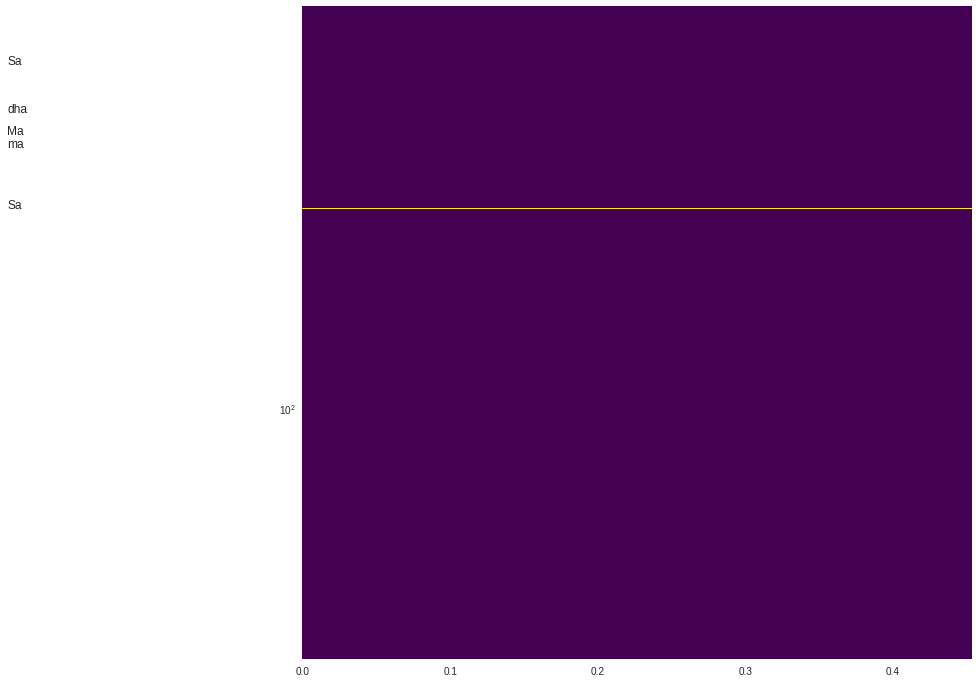

In [166]:
t_for_spectrogram = np.linspace(0, N/rate, j)
T, F = np.meshgrid(t_for_spectrogram, f)

spec_filtered = np.copy(spectrogram.T)
# spec_filtered = np.clip(spectrogram.T, 0, 10000)
# spec_filtered = 20 * np.log10(spec_filtered)
# print(T.shape, F.shape, spec_filtered.shape)
# spec_filtered[spec_filtered < 2000000] = 0

plt.pcolormesh(T, F, spec_filtered, cmap='viridis')

freqlines = np.array([261, 350, 372, 415, 522])
plt.semilogy()
# plt.hlines(freqlines, xmin=0, xmax=N/rate, linewidth=0.1, color='w', label='Sa')

plt.text(-0.2, 261, 'Sa', fontsize=12)
plt.text(-0.2, 350, 'ma', fontsize=12)
plt.text(-0.2, 372, 'Ma', fontsize=12)
plt.text(-0.2, 415, 'dha', fontsize=12)
plt.text(-0.2, 522, 'Sa', fontsize=12)

# plt.hlines(f, xmin=0, xmax=400, linewidth=1, color='w')
# plt.axhline(y=261, linewidth=1, color='w')
plt.grid(False)
plt.show()

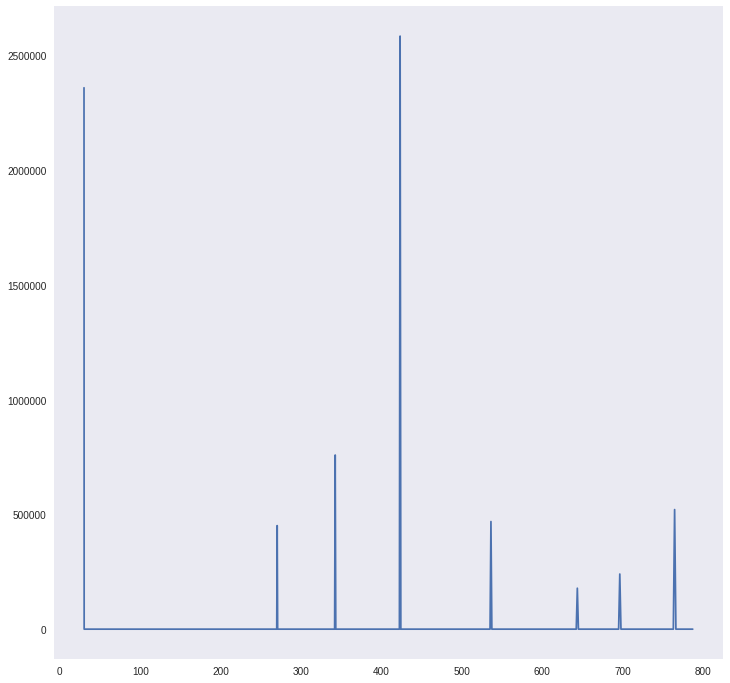

In [8]:
a = spectrogram[72]

# stackoverflow.com/a/4625132/4204843
# z = np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True] # minimas
z = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True] # maximas

gg = np.zeros(len(a))
gg[z] = a[z]
plt.plot(f, a)
plt.plot(f, gg)
plt.grid(False)

# convolution / correlation with gaussian blur filter

(1575,)


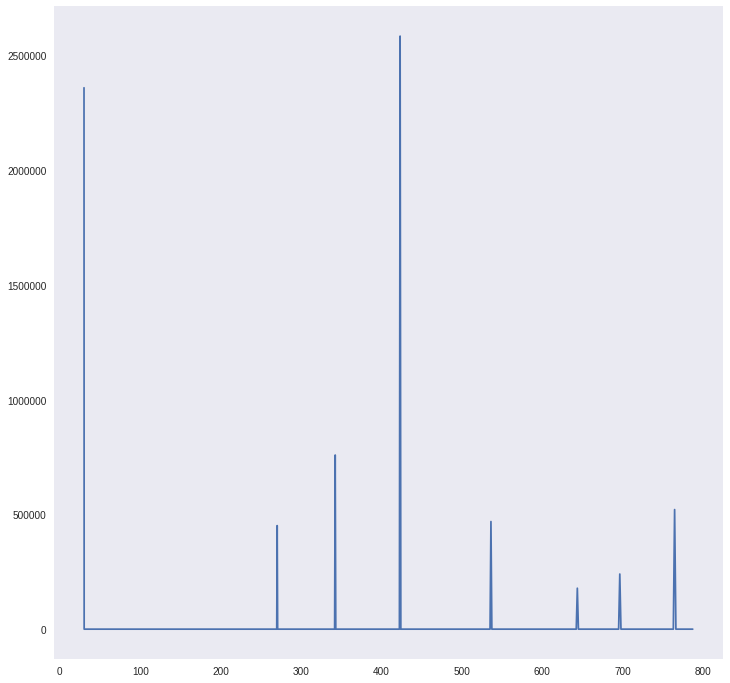

In [11]:
# plt.plot(f, a)
plt.plot(f, gg)
plt.grid(False)
print(gg.shape)

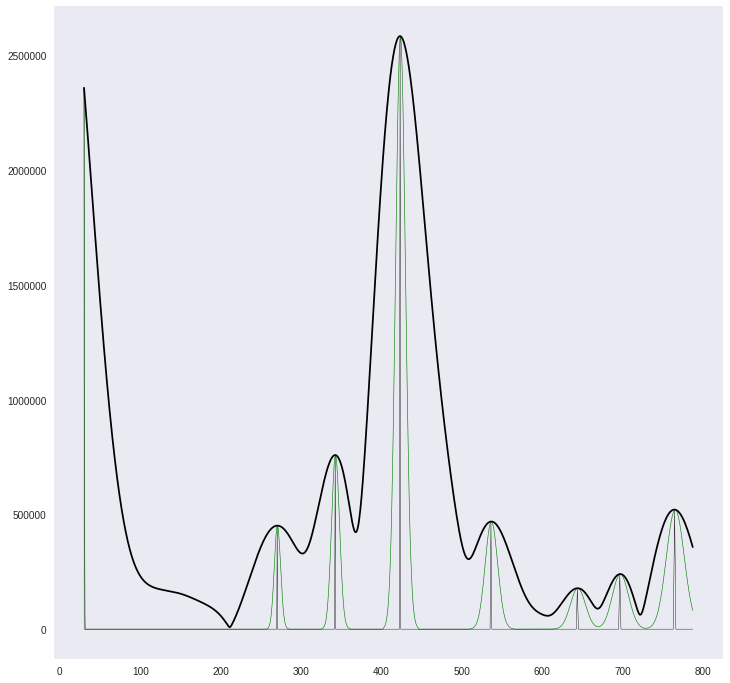

In [58]:
from scipy.signal import gaussian

a = spectrogram[72]


# z = np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True] # minimas
z = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True] # maximas


gg = np.zeros(len(a))
gg[z] = a[z]


blur_kernel = gaussian(50, std=7)

Q_corr = np.correlate(gg, blur_kernel, mode='same')



plt.plot(f, Q_corr, 'g', linewidth=0.6)




plt.plot(f, a, 'k')
plt.plot(f, gg, 'k', linewidth=0.4)
plt.grid(False)

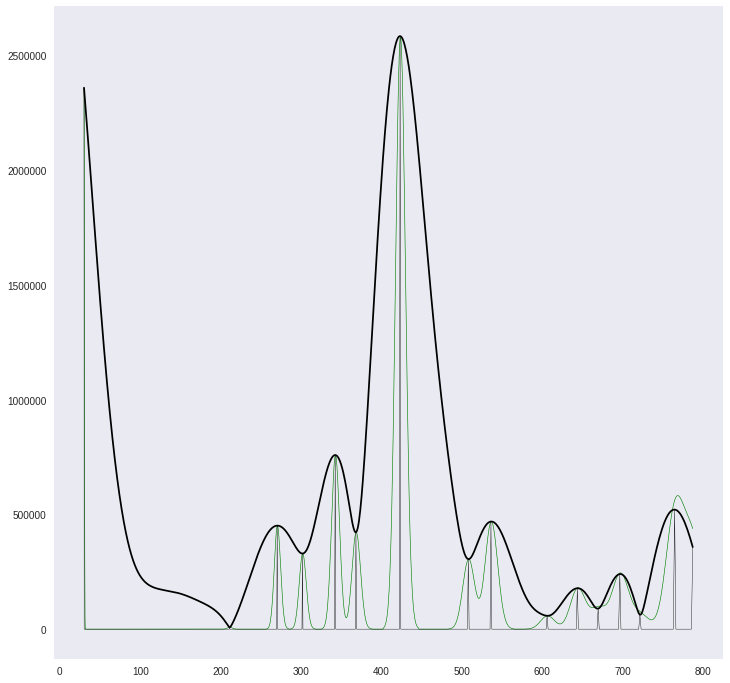

In [86]:



from scipy.signal import gaussian

a = spectrogram[72]


minimas_mask = np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True] # minimums
maximas_mask = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True] # maximums

gg = np.zeros(len(a))
gg[minimas_mask] = a[minimas_mask]
gg[maximas_mask] = a[maximas_mask]


blur_kernel = gaussian(50, std=7)
# 
Q_corr = np.correlate(gg, blur_kernel, mode='same')



plt.plot(f, Q_corr, 'g', linewidth=0.6)




plt.plot(f, a, 'k')
plt.plot(f, gg, 'k', linewidth=0.4)
plt.grid(False)

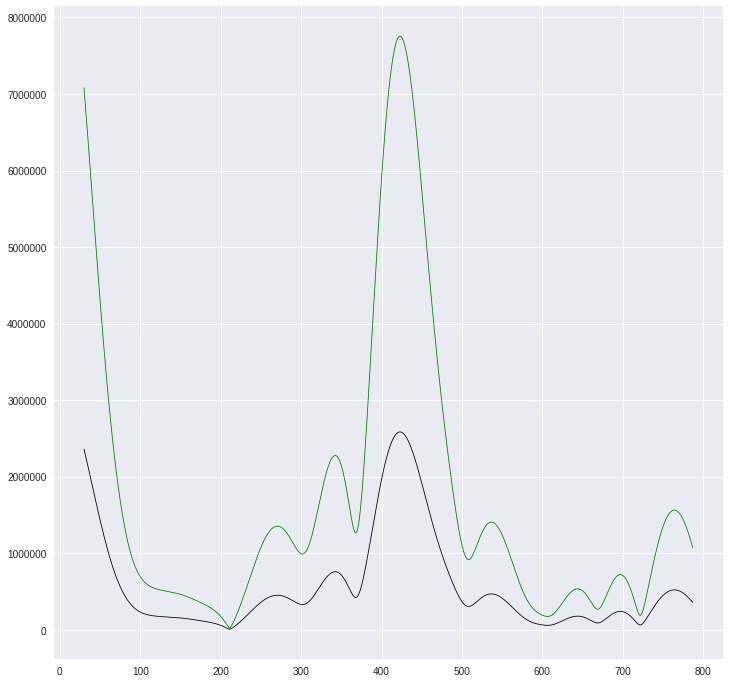

In [82]:
from scipy.signal import unit_impulse
sharp_kernel = unit_impulse(50, 'mid') * 3

# sharp_kernel = gaussian(500, std=1)
# plt.plot(sharp_kernel)

sharp_a = np.correlate(a, sharp_kernel, mode='same')


plt.plot(f, a      , 'k', linewidth=0.8)
plt.plot(f, sharp_a, 'g', linewidth=0.8)

# tryna fine-tune Q parameter

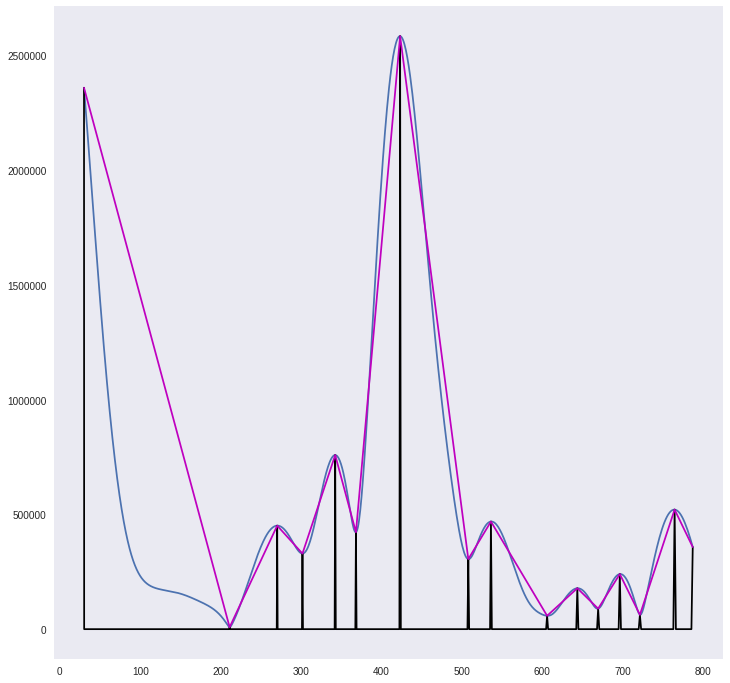

In [5]:
from scipy import interpolate

a = spectrogram[72]

# stackoverflow.com/a/4625132/4204843
minimas_mask = np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True] # minimas
maximas_mask = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True] # maximas


minimas = np.zeros(len(a))
maximas = np.zeros(len(a))

minimas[minimas_mask] = a[minimas_mask]
maximas[maximas_mask] = a[maximas_mask]

minimas_and_maximas = np.zeros(len(a))
minimas_and_maximas[minimas_mask] = a[minimas_mask]
minimas_and_maximas[maximas_mask] = a[maximas_mask]


# f_for_interpolation = f[minimas_mask | maximas_mask]
interpolation_function = interpolate.interp1d(f[minimas_mask | maximas_mask], a[minimas_mask | maximas_mask], kind='linear')
interpolation = interpolation_function(f)

plt.plot(f, a)
# plt.plot(f, minimas, 'r')
# plt.plot(f, maximas, 'g')
plt.plot(f, minimas_and_maximas, 'k')
plt.plot(f, interpolation, 'm')
plt.grid(False)

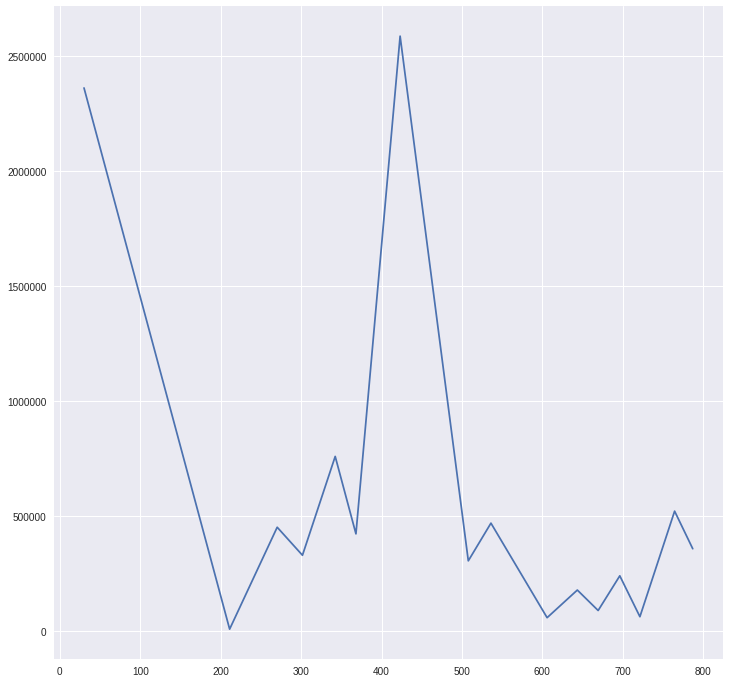

In [6]:

plt.plot(f[minimas_mask | maximas_mask], a[minimas_mask | maximas_mask])

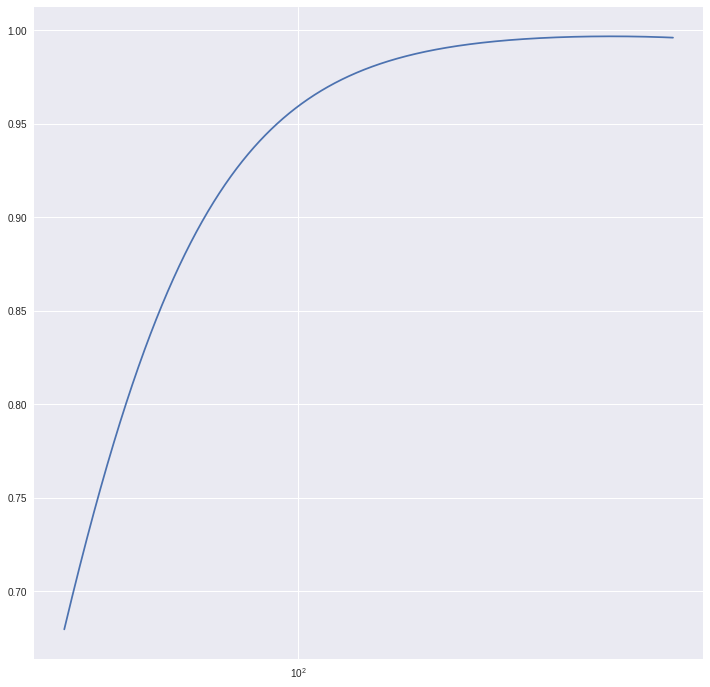

In [19]:
nperseg  = 11025//8
f_N = nperseg // 1
f = np.geomspace(30, nperseg//2, f_N) # second arg: nperseg//2 (Nyquist limit)

acoustic_filter = 12200**2 * f**2 / (f**2 + 20.6**2) / (f**2 + 12200**2)
plt.semilogx(f, acoustic_filter)

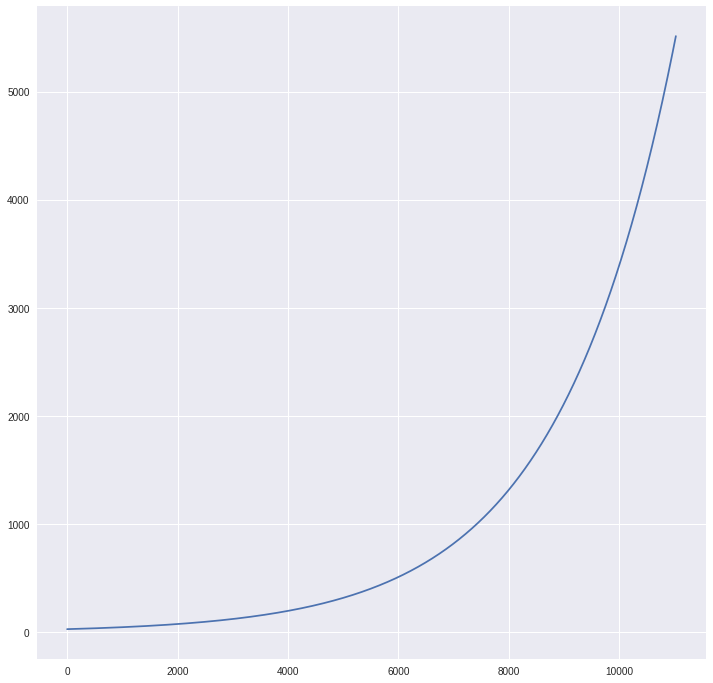

In [24]:
plt.plot(f)